We build a multi-layer perceptron with its hidden layers batch normalized, and contrast it with the version without
batch normalization.

We train and evaluate both versions of the multi-layer perceptron on MNIST dataset.

In [1]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt

import autodiff as ad
from autodiff import initializers
from autodiff import optimizers

random_state = np.random.RandomState(0)

In [2]:
def read_mnist_labels(fn):
  with gzip.open(fn, 'rb') as f:
    content = f.read()
    num_images = int.from_bytes(content[4:8], byteorder='big')
    labels = np.zeros((num_images, 10), dtype=np.float32)
    indices = np.fromstring(content[8:], dtype=np.uint8)
    labels[range(num_images), indices] += 1
    
  return labels  

In [3]:
def read_mnist_images(fn):
  with gzip.open(fn, 'rb') as f:
    content = f.read()
    num_images = int.from_bytes(content[4:8], byteorder='big')
    height = int.from_bytes(content[8:12], byteorder='big')
    width = int.from_bytes(content[12:16], byteorder='big')
    images = np.fromstring(content[16:], dtype=np.uint8).reshape((num_images, height, width))
  images = images.astype(np.float32) / 255.  
  return images  

Make sure you have the downloaded the following 4 files, and place them under the current directory.

In [4]:
train_images = read_mnist_images('train-images-idx3-ubyte.gz')
train_labels = read_mnist_labels('train-labels-idx1-ubyte.gz')
test_images = read_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = read_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [5]:
tni = initializers.TruncatedNormalInitializer(mean=0.0, stddev=0.01, seed=0)
zi = initializers.ZerosInitializer()
oi = initializers.OnesInitializer()

Build the version of MLP with batch norm. Note the function `fused_batch_norm` takes the moving statistics as input. They will be updated in training mode, and treated as estimates of population statistics in test mode.

In [6]:
def build_batch_norm(is_training=True, epsilon=1e-3, decay=0.997):
  inputs = ad.placeholder((None, 784))
  labels = ad.placeholder((None, 10))

  weight1 = ad.variable((784, 100), tni)
  offset1 = ad.variable((100,), zi)
  scale1 = ad.variable((100,), oi)
  moving_mean1 = ad.variable((100,), zi, trainable=False)
  moving_variance1 = ad.variable((100,), oi, trainable=False)

  weight2 = ad.variable((100, 100), tni)
  offset2 = ad.variable((100,), zi)
  scale2 = ad.variable((100,), oi)
  moving_mean2 = ad.variable((100,), zi, trainable=False)
  moving_variance2 = ad.variable((100,), oi, trainable=False)

  weight3 = ad.variable((100, 10), tni)
  bias3 = ad.variable((10,), zi)
  
  hidden1 = ad.matmul(inputs, weight1)
  hidden1 = ad.fused_batch_norm(
    hidden1, scale1, offset1, moving_mean1, moving_variance1,
    epsilon=epsilon, decay=decay, is_training=is_training)
  hidden1 = ad.sigmoid(hidden1)

  hidden2 = ad.matmul(hidden1, weight2)
  hidden2 = ad.fused_batch_norm(
    hidden2, scale2, offset2, moving_mean2, moving_variance2,
    epsilon=epsilon, decay=decay, is_training=is_training)
  hidden2 = ad.sigmoid(hidden2)

  logits = ad.matmul(hidden2, weight3) + bias3
  loss = ad.softmax_cross_entropy_loss(labels, logits)
  return inputs, labels, logits, loss

Build the version of MLP without batch norm.

In [7]:
def build_mlp():
  inputs = ad.placeholder((None, 784))
  labels = ad.placeholder((None, 10))

  weight1 = ad.variable((784, 100), tni)
  bias1 = ad.variable((100,), zi)
  weight2 = ad.variable((100, 100), tni)
  bias2 = ad.variable((100,), zi)
  weight3 = ad.variable((100, 10), tni)
  bias3 = ad.variable((10,), zi)

  hidden1 = ad.matmul(inputs, weight1) + bias1
  hidden1 = ad.sigmoid(hidden1)

  hidden2 = ad.matmul(hidden1, weight2) + bias2
  hidden2 = ad.sigmoid(hidden2)
  
  logits = ad.matmul(hidden2, weight3) + bias3
  loss = ad.softmax_cross_entropy_loss(labels, logits)
  return inputs, labels, logits, loss

We create three separate graphs, which hold the MLP w/ BN in training mode, MLP w/ BN in test mode, and the regular MLP w/o BN.

In [8]:
graph_bn = ad.Graph()
with graph_bn.as_default_graph():
  (inputs_bn, labels_bn, logits_bn, loss_bn,
    ) = build_batch_norm(is_training=True)

graph_bn_test = ad.Graph()
with graph_bn_test.as_default_graph():
  (inputs_bn_test, labels_bn_test, logits_bn_test, loss_bn_test,
   ) = build_batch_norm(is_training=False)  
  
graph = ad.Graph()
with graph.as_default_graph():
  inputs, labels, logits, loss = build_mlp()

Create three `RunTime` instances, so the three graphs can be run separately.

In [9]:
# MLP w/ BN in training mode
graph_bn.initialize_variables()
runtime_bn = ad.RunTime()
graph_bn.set_runtime(runtime_bn)
# MLP w/ BN in test mode
graph_bn_test.initialize_variables()
runtime_bn_test = ad.RunTime()
graph_bn_test.set_runtime(runtime_bn_test)
# MLP w/o BN 
graph.initialize_variables()
runtime = ad.RunTime()
graph.set_runtime(runtime)

# For BN, get the references to the variable nodes for training and test graph
# so we can assign variable's value in training graph to test graph  
weights_bn = graph_bn.get_variables(False)
weights_bn_test = graph_bn_test.get_variables(False)

In [10]:
gd = optimizers.GradientDescentOptimizer(alpha=0.01)

As we train both MLPs, we compute the accuracy on test set every 50 mini-batches.

In [11]:
iterations = 30000
batch = 50

accuracies_bn = []
accuracies = []

for i in range(iterations):
  which = random_state.choice(train_images.shape[0], batch, False)
  inputs_val = train_images[which].reshape((-1, 784))
  labels_val = train_labels[which]

  feed_dict_bn = {inputs_bn: inputs_val, labels_bn: labels_val}
  feed_dict = {inputs: inputs_val, labels: labels_val}

  
  with runtime_bn.forward_backward_cycle():
    gd.optimize(loss_bn, feed_dict_bn)
    
  with runtime.forward_backward_cycle():
    gd.optimize(loss, feed_dict)
    
  # compute test accuracy every 50 mini batches  
  if i % 50 == 0:
    inputs_val = test_images.reshape((-1, 784))
    labels_val = test_labels
    
    feed_dict_bn_test = {inputs_bn_test: inputs_val}
    feed_dict = {inputs: inputs_val}
    # assgin variable's value in training graph to test graph
    for w_bn_test, w_bn in zip(weights_bn_test, weights_bn):
      w_bn_test.set_val(w_bn.val)
    
    with runtime_bn_test.forward_backward_cycle():
      logits_bn_test_val = logits_bn_test.forward(feed_dict_bn_test)
      
    with runtime.forward_backward_cycle():
      logits_val = logits.forward(feed_dict)
     
    acc_bn = np.mean(np.argmax(logits_bn_test_val, axis=1) == np.argmax(labels_val, axis=1))
    acc = np.mean(np.argmax(logits_val, axis=1) == np.argmax(labels_val, axis=1))

    accuracies_bn.append((i, acc_bn))
    accuracies.append((i, acc))

accuracies_bn = np.array(accuracies_bn)
accuracies = np.array(accuracies)    

Test accuracy is plot as a function of training iterations.

**The MLP w/ BN clearly converges faster, and generalizes better the version w/o BN.**

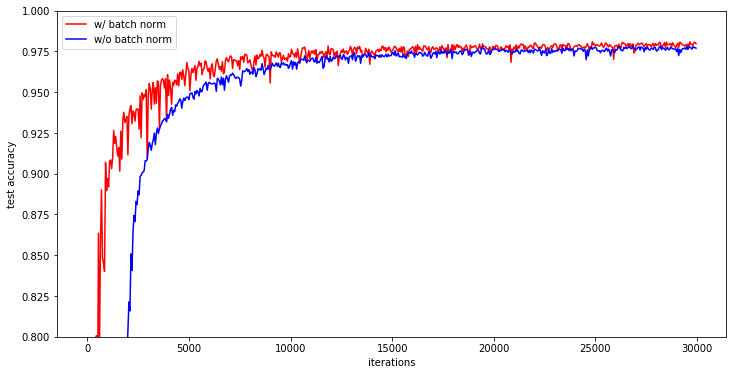

In [12]:
plt.plot(accuracies_bn[:, 0], accuracies_bn[:, 1], color='r')
plt.plot(accuracies[:, 0], accuracies[:, 1], color='b')

plt.ylim([0.8, 1.])
plt.legend(['w/ batch norm', 'w/o batch norm'])
plt.xlabel('iterations')
plt.ylabel('test accuracy')
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()